Testsätze und -pattern sowie Hilfsfunktion um Treffer in diesen zu rendern

In [1]:
from IPython.display import display_html

tests = [("Ich bin ein Moofoo der in Barfoo lebt.", "foo"),
         ("And the magician said: 'abracadabracadabra, simsalabim!'", "abracadabra"),
         ("CPM_annual_conference_announce", "announce"),
         ("I have an overlapping patpattpattern!", "pattern"),
         ("Pattern ganz am Ende?", "nde?"),
         ("Pattern ganz am Anfang?", "Pat")]

def print_highlighted_tests(search_fn):
    out = []
    for text, pattern in tests:
        start_idxs = search_fn(text, pattern)
        text = list(text)
        for idx in start_idxs:
            text[idx] = '<strong>' + text[idx]
            end_idx = idx+len(pattern)-1
            text[end_idx] += '</strong>'
        display_html("".join(text), raw=True)

Einfache Automatenimplementierung und Funktion um diese als Graph auszugeben

In [2]:
import pydotplus
from IPython.display import Image

class State:
    def __init__(self, id, final=False):
        self.id = id
        self.transitions = {}
        self.final = final
        
    def add_transition(self, label, target):
        self.transitions[label] = target
        
    def follow_path(self, path):
        if len(path) == 1:
            return self.transitions[path]
        return self.transitions[path[0]].follow_path(path[1:])
    
    def longest_prefix(self, path):
        if not path or path[0] not in self.transitions:
            return self, path
        return self.transitions[path[0]].longest_prefix(path[1:])
    
    def as_dot(self):
        out = []
        if self.final:
            out.append("{} [peripheries=2];\n".format(self.id))
        for transition, next_state in self.transitions.items():
            out.append("{} -> {} [label={}];\n"
                       .format(self.id, next_state.id, transition))
            out.extend([x for x in next_state.as_dot() if x not in out])
        return out
    
    def __str__(self):
        return "<State '{}' with {} transitions{}>".format(
            self.id, str(list(self.transitions.keys())),
            " final" if self.final else "")
    
    __repr__ = __str__
    
def print_automaton(state):
    dot_src = "digraph automaton { rankdir=\"LR\"; rank=\"same\"; %s }" % "".join(state.as_dot())
    return Image(pydotplus.graph_from_dot_data(dot_src).create_png(prog='dot'))

# String Matching
## Simple Pattern Matching
- eine Schleife, die über den Text itertiert (kann beendet werden,
  sobald der restliche Text kürzer wäre als das Pattern selbst)
- eine zweite Schleife, die an jeder Position des Textes über die
  nächsten Buchstaben und das Pattern iteriert und abbricht, sobald
  ein Buchstabe im Pattern nicht mit dem aktuellen Buchstaben im Text
  übereinstimmt
- wenn die zweite Schleife komplett durchlaufen wurde, wurde ein Match
  gefunden

In [3]:
def simple_search(text, pattern):
    # Walk forwards through the text
    for text_idx in range(len(text) - len(pattern) + 1):
        # Walk forwards through the pattern
        for pat_idx, char in enumerate(pattern):
            # Does the text match the pattern?
            if char != text[text_idx+pat_idx]:
                # Nay, go to the next character in the text
                # and try the pattern again
                break
        else:
            # Yay, we got a match! (Because all pattern symbols matched)
            yield text_idx
            
# PROBLEM: In case of a mismatch, we always start reading the **full** pattern again,
#          just for the **next** position in the text -> Inefficient!

print_highlighted_tests(simple_search)

Ich bin ein Moo foo der in Bar foo lebt.

And the magician said: ' abracad abra cadabra , simsalabim!'

CPM_annual_conference_ announce

I have an overlapping patpatt pattern !

Pattern ganz am E nde?

Pat tern ganz am Anfang?

## Präfix-basierte Ansätze
### Knuth-Morris-Pratt
- das selbe Prinzip wie beim Simple Pattern Matching
- das Pattern wird jedoch bei einem Mismatch von Buchstaben “weiter
  nach vorne geschoben”
- hierbei hilft eine Prefix-Tabelle (auch Next-Funktion) die die
  “Verschiebepositionen” speichert. (Die Verschiebeposition ist die Länge des
  längsten Suffix des Teils des Patterns der gefunden wurde, der gleichzeitig
  Präfix des gesamten Patterns ist)

<!-- TODO: besserer Code hier?! -->

In [4]:
def get_prefix_table(pattern):
    i, j = 0, -1
    prefix_table = [-1] * (len(pattern) + 1)
    while i < len(pattern):
        while j >= 0 and pattern[j] != pattern[i]:
            j = prefix_table[j]
        i += 1
        j += 1
        if i == len(pattern):
            prefix_table[i] = j
        elif pattern[i] != pattern[j]:
            prefix_table[i] = j
        else:
            prefix_table[i] = prefix_table[j]
    return prefix_table

print(get_prefix_table('abracadabra'))

[-1, 0, 0, -1, 1, -1, 1, -1, 0, 0, -1, 4]


| 0 | 1 | 2 |  3 | 4 |  5 | 6 |  7 | 8 | 9 | 10 | match |
|---|---|---|----|---|----|---|----|---|---|----|-------|
| a | b | r |  a | c |  a | d |  a | b | r |  a |       |
|-1 | 0 | 0 | -1 | 1 | -1 | 1 | -1 | 0 | 0 | -1 |    4  |

Table: Präfix-Tabelle für das Pattern *abracadabra*

In [5]:
def kmp_search(text, pattern):
    prefix_table = get_prefix_table(pattern)
    text_idx, pat_idx = 0, 0
    while text_idx < len(text):
        while pat_idx >= 0 and text[text_idx] != pattern[pat_idx]:
            pat_idx = prefix_table[pat_idx]
        text_idx += 1
        pat_idx += 1
        if pat_idx == len(pattern):
            yield text_idx - len(pattern)
            pat_idx = prefix_table[pat_idx]

print_highlighted_tests(kmp_search)

Ich bin ein Moo foo der in Bar foo lebt.

And the magician said: ' abracad abra cadabra , simsalabim!'

CPM_annual_conference_ announce

I have an overlapping patpatt pattern !

Pattern ganz am E nde?

Pat tern ganz am Anfang?

### Shift-And
- Automat wird mit Bitmasken repräsentiert
- Bitmasken für jeden Buchstaben im Pattern erstellen (alle anderen
  Buchstaben haben 0-Vektor als Bitmaske)
- Vektor der einen Automaten repräsentiert, dessen Anfangszustand
  immer aktiv ist, wird durch Shift-Operationen “durchlaufen” und mit
  der Bitmaske des aktuell gelesenen Buchstabens im Text “verundet”
- wenn der letzte Zustand des Automaten aktiv ist, wurde das Pattern
  gefunden
- Endianness der Vektoren ist zu beachten! (immer Big Endian?)

In [6]:
from bitstring import BitArray
from collections import defaultdict

def get_bit_table(pattern):
    alphabet = set(pattern)
    # Every entry represents the *reversed* pattern, with a 1
    # at the positions with the character
    table = {char: BitArray('0b' + ''.join('1' if c == char else '0'
                                           for c in reversed(pattern)))
             for char in alphabet}
    return table

[get_bit_table('foo'), get_bit_table('abracadabra')]

[{'f': BitArray('0b001'), 'o': BitArray('0b110')},
 {'a': BitArray('0b10010101001'),
  'b': BitArray('0b00100000010'),
  'c': BitArray('0b00000010000'),
  'd': BitArray('0b00001000000'),
  'r': BitArray('0b01000000100')}]

| letter||   |   |   |   |   |   |   |   |   |   |
|----|---|---|---|---|---|---|---|---|---|---|---|
| a  | 1 | 0 | 0 | 1 | 0 | 1 | 0 | 1 | 0 | 0 | 1 |
| b  | 0 | 0 | 1 | 0 | 0 | 0 | 0 | 0 | 0 | 1 | 0 |
| r  | 0 | 1 | 0 | 0 | 0 | 0 | 0 | 0 | 1 | 0 | 0 |
| c  | 0 | 0 | 0 | 0 | 0 | 0 | 1 | 0 | 0 | 0 | 0 |
| d  | 0 | 0 | 0 | 0 | 1 | 0 | 0 | 0 | 0 | 0 | 0 |
| \* | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 |

Table: Bitmasken-Tabelle für das Pattern *abracadabra*

In [7]:
def shift_and_search(text, pattern):
    m = len(pattern)
    bit_table = get_bit_table(pattern)
    empty_vec = BitArray(length=m)
    # Vector that represents a full match on the pattern
    found_vec = BitArray('0b1' + '0'*(m-1))  # '1000...'
    # Vector that adds a 'empty_word' transition on the first state
    # to itself
    init_vec = BitArray('0b' + '0'*(m-1) + '1')  # '...0001'
    
    # In the beginning, all states in the NFA are inactive
    automaton = BitArray(length=m)  # '0000...'
    for text_idx, char in enumerate(text):
        char_vec = bit_table.get(char, empty_vec)
        automaton <<= 1        # shift/advance in the NFA
        automaton |= init_vec  # activate the first state
        automaton &= char_vec  # and/activate the character states
        if automaton & found_vec != empty_vec:  # Is the final state active?
              yield text_idx - m + 1

print_highlighted_tests(shift_and_search)

Ich bin ein Moo foo der in Bar foo lebt.

And the magician said: ' abracad abra cadabra , simsalabim!'

CPM_annual_conference_ announce

I have an overlapping patpatt pattern !

Pattern ganz am E nde?

Pat tern ganz am Anfang?

### Shift-Or
- gleiches Konzept wie beim Shift-And Verfahren
- hier repräsentieren 0en aktive und 1en inaktive Zustände, so kann der
  Schritt des “aktiv machens” des ersten Zustands des Automaten gespart
  werden, da beim shift automatisch eine neue 0 (aktiver Zustand) hinzugefügt
  wird
- alle Bitvektoren sind hier natürlich invertiert

In [8]:
def shift_or_search(text, pattern):
    m = len(pattern)
    empty_vec = BitArray('0b' + '1'*m)  # '1111...'
    
    # Vector that represents a full match on the pattern
    found_vec = BitArray('0b0' + '1'*(m-1))  # '0111...'
    
    # XORing with an all-one array of same length creates the complement
    bit_table = {char: vec ^ empty_vec
                 for char, vec in get_bit_table(pattern).items()}
    
    # In the beginning, all states in the NFA are inactive
    automaton = BitArray('0b' + '1'*m)  # '1111...'
    for text_idx, char in enumerate(text):
        automaton = (automaton << 1 | bit_table.get(char, empty_vec))
        if (automaton | found_vec) != empty_vec:
              yield text_idx - m + 1

print_highlighted_tests(shift_or_search)

Ich bin ein Moo foo der in Bar foo lebt.

And the magician said: ' abracad abra cadabra , simsalabim!'

CPM_annual_conference_ announce

I have an overlapping patpatt pattern !

Pattern ganz am E nde?

Pat tern ganz am Anfang?

## Suffix-basierte Ansätze
### Boyer-Moore
- Pattern wird wie zuvor von links nach rechts durch den Text
  geschoben, jedoch wird nun das Pattern von rechts nach links
  durchlaufen (in natürlichen Sprachen wird so üblicherweise früher
  ein Mismatch gefunden und das Pattern kann schneller
  verschoben werden)
- für die Verschiebung werden zwei Heuristiken angewandt
    *   **Bad-Character Heuristik**<br>
        bei einem Mismatch kann das Pattern soweit verschoben werden,
        dass der aktuell im Text gelesene Buchstabe mit dem letzten
        vorkommen dieses Buchstabens im Pattern aligniert ist, wenn
        dieser Buchstabe gar nicht im Pattern vorkommt, kann das Pattern
        um seine ganze Länge verschoben werden
    *   **Good-Suffix Heuristik**<br>
        Wenn das bis zum Mismatch gelesene Suffix des Patterns nochmals
        Infix des Patterns ist, kann das Pattern soweit verschoben
        werden, bis der gelesene Teil mit diesem Infix aligniert ist,
        kommt dieses Suffix kein zweites malim Pattern vor, kann das
        Pattern um seine ganze Länge verschoben werden
- es wird immer die maximale Verschiebung die sich durch diese
  Heristiken ergeben angewandt

<!-- TODO: Code -->

### Horspool
- Wie bei Boyer-Moore wird der Text von links nach rechts, das Pattern aber
  von rechts nach links durchlaufen
- sobald ein Mismatch erreicht wird, wird das Pattern soweit verschoben, dass
  das gerade gelesene Zeichen im Text mit dem letzen

<!-- TODO: debug horspool search! (überlappende Vorkommen nicht gefunden...) -->

In [9]:
def get_horspool_table(pattern):
    return {char: len(pattern)-j-1
            for j, char in enumerate(pattern[:-1])}

get_horspool_table('announce')

{'a': 7, 'c': 1, 'n': 2, 'o': 4, 'u': 3}

In [10]:
def horspool_search(text, pattern):
    n = len(text) - 1
    m = len(pattern) - 1
    table = get_horspool_table(pattern)
    pos = -1
    # Walk through text from left to right
    while pos <= n - m:
        j = m
        # Walk through pattern from right to left
        while j >= 0 and text[pos + j] == pattern[j]:
            j -= 1
        # Did we get through the whole pattern?
        if j == -1:
            yield pos
        current_char = text[pos+m]
        # What's the indx of the character in the pattern?
        # If the character is not in the table, use the pattern length
        last_idx_in_pattern = table.get(current_char, m)
        pos += last_idx_in_pattern

print_highlighted_tests(horspool_search)

Ich bin ein Moo foo der in Bar foo lebt.

And the magician said: ' abracad abra cadabra , simsalabim!'

CPM_annual_conference_ announce

I have an overlapping patpatt pattern !

Pattern ganz am E nde?

Pat tern ganz am Anfang?

## Faktor-basierte Ansätze

**TODO**: Allgemeine Idee/Ansatz

### Backward Nondeterministic DAWG Matching

Ähnlich wie Shift/And, in diesem Fall wird aber nach Faktoren/Infixen des Pattern gesucht um so die Verschiebung zu maximieren.

In [11]:
def bndm_search(text, pattern):
    bit_table = get_bit_table(pattern)
    # Sincew're iterating backwards through the pattern,
    # we have to flip the vectors ('0001' -> '1000')
    for vec in bit_table.values():
        vec.reverse()
    empty_vec = BitArray(length=len(pattern))
    found_vec = BitArray('0b1' + '0'*(len(pattern)-1))
    n = len(text) - 1
    m = len(pattern)
    pos = -1
    # Go throught text left-to-right
    while pos <= n - m:
        j = m
        last = m
        D = BitArray('0b' + '1'*m)
        # Go through pattern right-to-left
        while D != empty_vec:
            char_vec = bit_table.get(text[pos+j], empty_vec)
            D &= char_vec
            j -= 1
            if D & found_vec != empty_vec:
                if j > 0:
                    last = j
                else:
                    yield pos + 1
            D <<= 1
        pos += last
        
print_highlighted_tests(bndm_search)

Ich bin ein Moo foo der in Bar foo lebt.

And the magician said: ' abracad abra cadabra , simsalabim!'

CPM_annual_conference_ announce

I have an overlapping patpatt pattern !

Pattern ganz am E nde?

Pat tern ganz am Anfang?

### Backward Oracle Matching

**TODO**: Erklärung

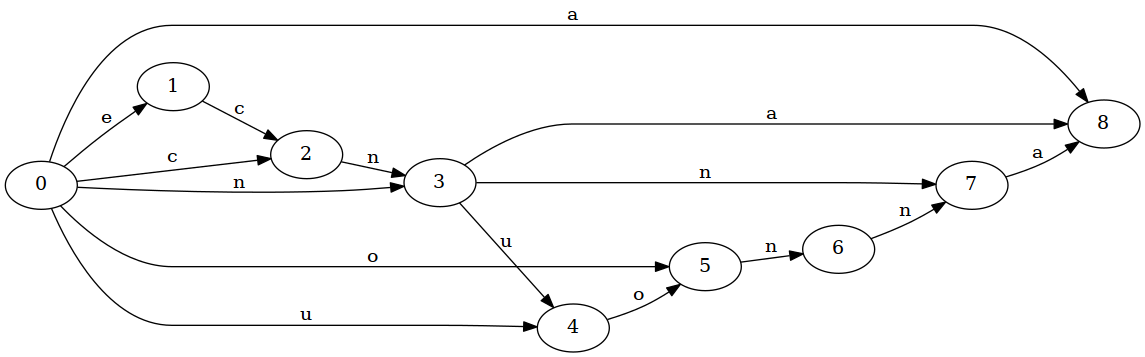

In [12]:
def build_oracle(pattern):
    pattern = pattern[::-1]
    m = 0
    S = {}
    start = State(m)
    S[m] = None
    cur_state = start
    for idx, char in enumerate(pattern):
        m += 1
        new_state = State(m)
        cur_state.add_transition(char, new_state)
        k = S[m-1]
        while k is not None and char not in k.transitions:
            k.add_transition(char, new_state)
            k = S[k.id]
        if k is None:
            S[m] = start
        else:
            S[m] = k.transitions[char]
        cur_state = new_state
    return start
        
oracle = build_oracle('announce')
print_automaton(oracle)

In [13]:
def bom_search(text, pattern):
    oracle = build_oracle(pattern)
    pos = -1
    n = len(text) - 1
    m = len(pattern)
    while pos <= n - m:
        current = oracle
        j = m
        while j > 0 and current is not None:
            char = text[pos+j]
            current = current.transitions.get(char, None)
            j -= 1
        if current is not None:
            yield pos + 1
        pos += j + 1
        
print_highlighted_tests(bom_search)

Ich bin ein Moo foo der in Bar foo lebt.

And the magician said: ' abracad abra cadabra , simsalabim!'

CPM_annual_conference_ announce

I have an overlapping patpatt pattern !

Pattern ganz am E nde?

Pat tern ganz am Anfang?

# Multiples String Matching

## Präfix-basierte Ansätze

### Multiple Shift-And

### Aho-Corasick

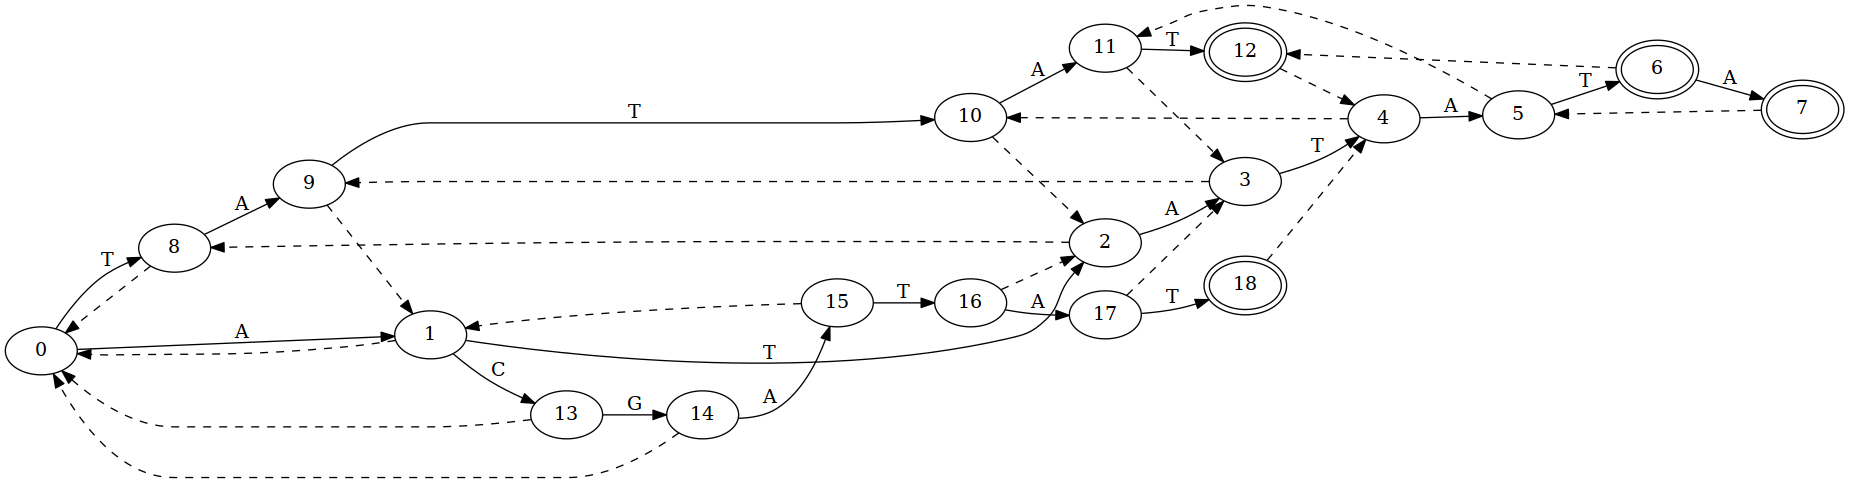

In [14]:
class AhoCorasickAutomaton:
    def __init__(self, strings):
        idx = 0
        self.parents = {}
        self.states = {}
        self.start = State(idx)
        self.states = [self.start]
        self.finals = defaultdict(list)
        for s in strings:
            cur, rest = self.start.longest_prefix(s)
            for char in rest:
                idx += 1
                new_state = State(idx)
                cur.add_transition(char, new_state)
                self.parents[new_state.id] = cur
                self.states.append(new_state)
                cur = new_state
            cur.final = True
            self.finals[cur.id].append(s)
        self.supply_links = self._build_supply_links()
    
    def as_dot(self):
        out = self.start.as_dot()
        for id, state in self.supply_links.items():
            if state is None:
                continue
            out.append("{} -> {} [style=\"dashed\"]"
                       .format(id, state.id))
        return out
    
    def _root_distance(self, state):
        dist = 0
        parent = state
        while parent != self.start:
            parent = self.parents[parent.id]
            dist += 1
        return dist
    
    def _transversal_iter(self):
        return sorted(self.states, key=self._root_distance)
            
    def _build_supply_links(self):
        links = {self.start.id: None}
        for current in self._transversal_iter():
            if current == self.start:
                continue
            parent = self.parents[current.id]
            sigma = next(
                char for char, child in parent.transitions.items()
                if child == current)
            down = links[parent.id]
            while down is not None and sigma not in down.transitions:
                down = links[down.id]
            if down is not None:
                links[current.id] = down.transitions[sigma]
                if links[current.id].final:
                    current.final = True
                    self.finals[current.id].append(
                        self.finals[links[current.id].id])
            else:
                links[current.id] = self.start
        return links

acaut = AhoCorasickAutomaton(['ATATATA', 'TATAT', 'ACGATAT'])
print_automaton(acaut)

[0, 7]


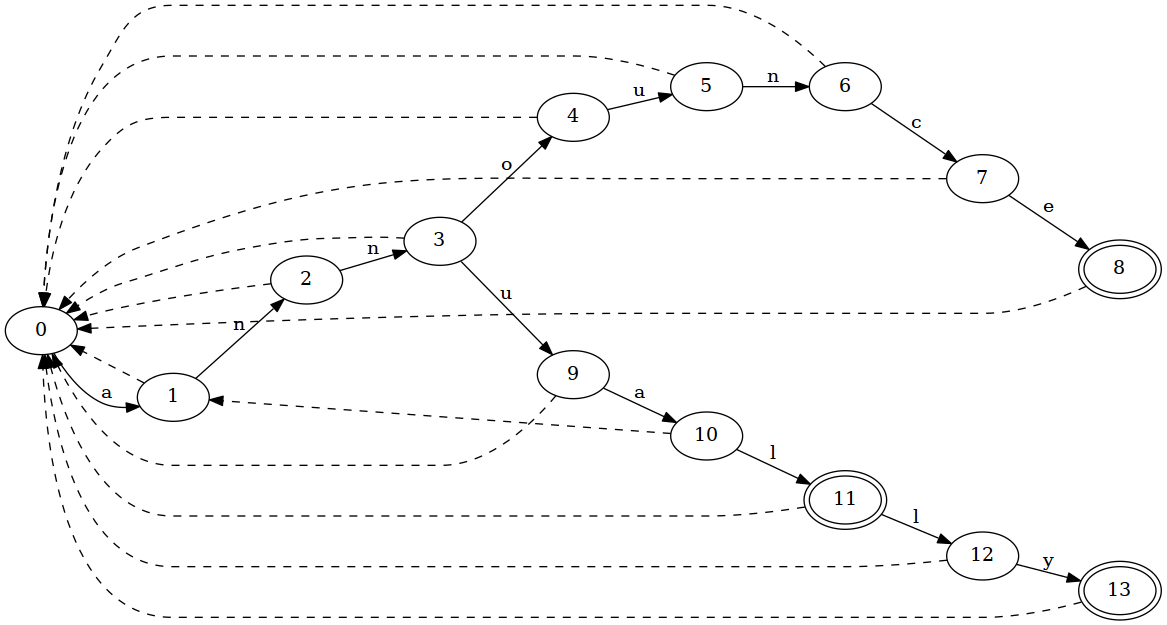

In [15]:
def ac_search(text, patterns):
    trie = AhoCorasickAutomaton(patterns)
    current = trie.start
    for pos, char in enumerate(text):
        while (char not in current.transitions and
               trie.supply_links[current.id] is not None):
            current = trie.supply_links[current.id]
        if char in current.transitions:
            current = current.transitions[char]
        else:
            current = trie.start
        if current.final:
            for pat in trie.finals[current.id]:
                yield pos - len(pat) + 1

text = "annual_announce"
patterns = ["announce", "annual", "annually"]
print(list(ac_search(text, patterns)))
print_automaton(AhoCorasickAutomaton(patterns))

## Suffix-basierte Ansätze

### Wu-Manber

## Faktor-basierte Ansätze

### Multiple BNDM

### Set Backward Oracle Matching

# Reguläre Ausdrücke

## Parsen in einen Syntaxbaum

## Automatenaufbau

### Nach Thompson

### Nach Glushkov

## Suche

### Bit-Parallele Suche

### Filter-Ansätze

# Approximative Suche

## Levenshtein mit Wagner-Fisher

## Levenshtein mit Ukkonnen

## Bit-Paralleler Levenshtein